In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,accuracy_score
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import seaborn as sns

In [2]:
df = pd.read_csv("churn_modelling.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
df.shape

(10000, 14)

In [4]:
df.info

<bound method DataFrame.info of       RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfP

In [5]:
target = "Exited"
x = df.drop(columns=[target])
y = df[target]

In [6]:
x

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [7]:
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [8]:
x = x.copy()
for col in x.columns:
    if x[col].dtype == "object":
        x[col] = x[col].fillna("MISSING")
        x[col] = LabelEncoder().fit_transform(x[col])
    else:
        x[col] = x[col].fillna(x[col].median())

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=1),
    "XGBoost": XGBClassifier(
        n_estimators=300,learning_rate=0.05,use_label_encoder=False,eval_metric="logloss",random_state=42
    )
}
results = {}
scored_dfs = {}

In [11]:
for name,model in models.items():
    model.fit(x_scaled,y)
    y_pred = model.predict(x_scaled)
    y_prob = model.predict_proba(x_scaled)[:,1]

    acc = accuracy_score(y,y_pred)
    roc_auc = roc_auc_score(y,y_pred)
    cm = confusion_matrix(y,y_pred)
    report = classification_report(y,y_pred,output_dict=True)

    results[name] = {
        "model": model,
        "accuracy": acc,
        "roc_auc": roc_auc,
        "conf_matrix": cm,
        "report": report
    }

    scored_df = df.copy()
    scored_df[f"{name}_Predicted_Churn"] = y_pred
    scored_df[f"{name}_Churn_Probability"] = y_pred
    scored_dfs[name] = scored_df

C:\Users\Sheldon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
best_model_name = max(results,key = lambda x: results[x]["roc_auc"])
best_model = results[best_model_name]["model"]

model_path = "final_best_model.pkl"
joblib.dump(best_model,model_path)

['final_best_model.pkl']

In [13]:
scored_csv_path = "scored_customers.csv"
scored_dfs[best_model_name].to_csv(scored_csv_path,index=False)

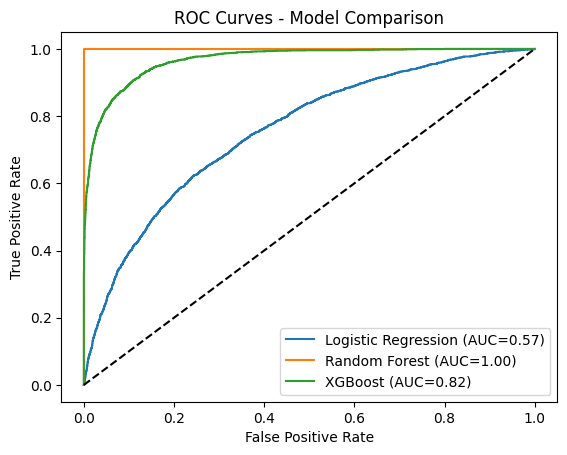

In [14]:
plt.figure()
for name , res in results.items():
    fpr , tpr , _ = roc_curve(y, res["model"].predict_proba(x_scaled)[:,1])
    plt.plot(fpr,tpr,label=f"{name} (AUC={res['roc_auc']:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend()
roc_img_path = "roc_curves_comparison.png"
plt.savefig(roc_img_path)
plt.show()

C:\Users\Sheldon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


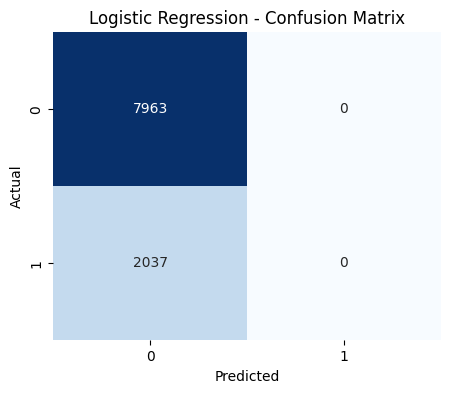

C:\Users\Sheldon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


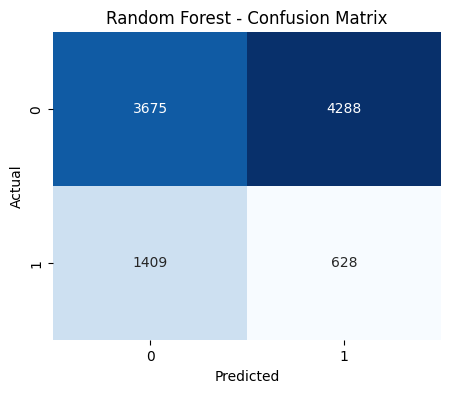

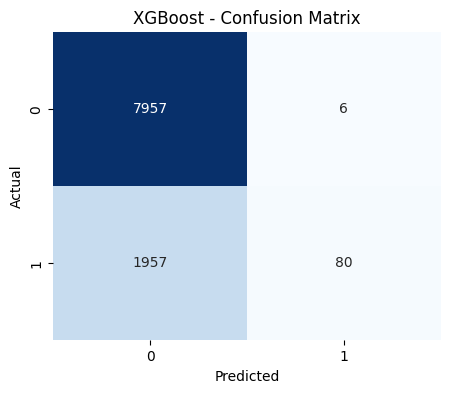

In [15]:
for name, model in models.items():
    y_pred = model.predict(x)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

C:\Users\Sheldon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


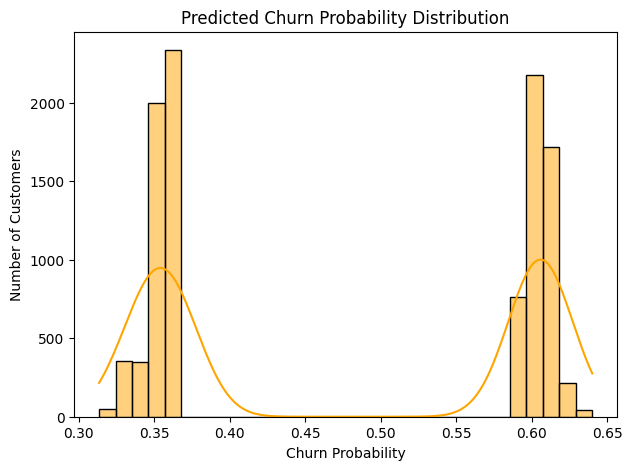

In [16]:
best_model = models["Random Forest"] 
y_proba = best_model.predict_proba(x)[:,1]

plt.figure(figsize=(7,5))
sns.histplot(y_proba, bins=30, kde=True, color="orange")
plt.title("Predicted Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Number of Customers")
plt.show()

In [17]:
pdf_path = "final_churn_report.pdf"
doc= SimpleDocTemplate(pdf_path)
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("Customer Churn Prediction - Model Comparison Report",styles["Title"]))
elements.append(Spacer(1,12))
elements.append(Paragraph(f"Target column: {target}",styles["Normal"]))
elements.append(Paragraph(f"Rows used for training: {len(df)}",styles["Normal"]))
elements.append(Spacer(1,12))

In [22]:
table_data = [["Model","Accuracy","ROC-AUC"]]
for name , res in results.items():
    table_data.append([name ,f"{res['accuracy']:.3f}",f"{res['roc_auc']:.3f}"])
comp_table = Table(table_data,colWidths=[200,100,100])
comp_table.setStyle(TableStyle([
    ("Background",[0,0],[-1,0],colors.grey),
    ("Grid",[0,0],[-1,-1],1,colors.black),
    ("Align",[0,0],[-1,-1],"CENTER"),
]))
elements.append(Paragraph("Model Performance Comparison:",styles["Heading2"]))
elements.append(comp_table)
elements.append(Spacer(1,12))

In [23]:
elements.append(Paragraph("ROC Curves:", styles["Heading2"]))
elements.append(Image(roc_img_path,width=400,height=300))

In [24]:
for name in ["Random Forest","XGBoost"]:
    if name in results:
        importances = results[name]["model"].feature_importances_
        feat_imp = sorted(zip(x.columns,importances),key=lambda x: x[1],reverse=True)[:10]
        feat_table = Table([[f,round(v,3)] for f , v in feat_imp],colWidths=[200,100])
        feat_table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
            ("ALIGN", (0, 0), (-1, -1), "CENTER"),
        ]))
        elements.append(Paragraph(f"Top 10 Features Driving Churn - {name}:", styles["Heading2"]))
        elements.append(feat_table)
        elements.append(Spacer(1, 12))
doc.build(elements)

In [25]:
print("Training complete with 3 models.")
print(f"Best model: {best_model_name}")
print(f"Model saved to: {model_path}")
print(f"Scored data saved to: {scored_csv_path}")
print(f"PDF report saved to: {pdf_path}")

Training complete with 3 models.
Best model: Random Forest
Model saved to: final_best_model.pkl
Scored data saved to: scored_customers.csv
PDF report saved to: final_churn_report.pdf
